In [ ]:
#1D non-isothermal

'''
 - CALCULATE THE TEMP WITH THE CORRECT AREA
 - adjust the heat capacity and enthalpy calculation way
 - Solve for temp with actual enthalpy

- finish my paper 
- finish 2D

- Modeling to be done with electrolyzer
'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [156]:
def heats(T):
    #heats of reaction and heat capacity calculation from NIST
    t = T/1000

    #CH4
    A =	-0.703029
    B =	108.4773
    C =	-42.52157
    D =	5.862788
    E =	0.678565
    F =	-76.84376
    G =	158.7163
    H =	-74.87310

    dH_CH4 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CH4 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2O
    A =   30.09200
    B =   6.832514
    C =   6.793435
    D =  -2.534480
    E =   0.082139
    F =  -250.8810
    G =   223.3967
    H =  -241.8264

    dH_H2O = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2O = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO
    A =   25.56759
    B =   6.096130
    C =   4.054656
    D =  -2.671301
    E =   0.131021
    F =  -118.0089
    G =   227.3665
    H = -110.5271

    dH_CO = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO2
    A =   24.99735
    B =   55.18696
    C =  -33.69137
    D =   7.948387
    E =  -0.136638
    F =  -403.6075
    G =   228.2431
    H =  -393.5224

    dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2
    A =  33.066178
    B = -11.363417
    C =  11.432816
    D = -2.772874
    E = -0.158558
    F = -9.980797
    G =  172.707974
    H =  0.0

    dH_H2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #Ar
    A =	20.78600
    B =	2.825911*10**-7
    C =	-1.464191*10**-7
    D =	1.092131*10**-8
    E =	-3.661371*10**-8
    F =	-6.197350
    G =	179.9990
    H =	0

    dH_Ar = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_Ar = A + B*t + C*t**2 + D*t**3 + E/(t**2) #J/mol K

    dHsmr = (3*dH_H2 + dH_CO - dH_CH4 - dH_H2O + 206.1)*10**3 #J/mol
    dHwgs = (dH_H2 + dH_CO2 - dH_CO - dH_H2O - 41.15)*10**3 #J/mol
    # print(dHsmr)
    # print(dHwgs)
    # print([Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2])
    return dHsmr, dHwgs, [Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Cp_Ar], [dH_CH4 + -74.5, dH_H2O + -241.8, dH_CO + -110.5, dH_CO2 + -393.52, dH_H2, dH_Ar]

In [157]:
#WANT TO RE-ARANGE CONSTANTS

#reactor constant
L = 0.0609 #m
R_inner = 0.00225 #m outside radius of inner tube
R_outer = 0.0035 #m inside radius of outer tube
Rin_outer = 0.003154/2 #m innder radius of inner tube

A = np.pi * ((R_outer)**2-(R_inner)**2) #m^2 AXIAL AREA (GAS FLOW)
V = A*L #m^3
Souter = 2*np.pi*R_outer*L #m^2 RADIAL AREA (HEAT FLUX AND REACTION)
Sinner = 2*np.pi*R_inner*L #m^2 inner RADIAL AREA (HEAT FLUX)

Ain = np.pi * (Rin_outer)**2 
Vin = Ain*L

print(A)
print(Ain)

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants WHEN CHANGING THE TEMPERATURE YOU NEED TO ADJUST THE INITIAL GUESS -- USING ODEINT MIGHT BE FOR BETTER CONVERSION
Tin = 450 #K
P = 3 #bar or atm
Rgas = 8.3144598 * 10**-5

sccm0 = np.array([16.16, 43.04, 0, 0, 9, 3.49])
mols0 = sccm0/22400 * 273 / Tin * P / 1 / 60

boundary = np.concatenate((mols0, [np.sum(mols0)/Ain*33*(Tin - 298.15)])) #adjust the heat capacity
print(boundary)

#rate equation constants
Rreact = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 0.6

I = 9 #curent in Amps
F = 96485 #faradays constant

Uouter = 18.6 #J (s K m2)^-1.     Uouter = 0.116/Souter
Ts = 298 #K
Uinner = Uouter

q_furn = 200500 #W/m2 #16000*Souter #J/s  q_furn= 2

print(q_furn*Souter)
print(Souter*Uouter*(-1050 + Ts))
print(q_furn + Uouter*(-1050 + Ts))
MM = np.array([16.04, 18.01528, 28.01, 44.009, 2.016, 39.948])
m0 = np.dot(MM, mols0)
print(m0) #kg/s


2.2580197197676646e-05
7.812917876399411e-06
[2.18833333e-05 5.82833333e-05 0.00000000e+00 0.00000000e+00
 1.21875000e-05 4.72604167e-06 6.22653131e+04]
268.5218201191784
-18.73251073501732
186512.8
0.0016143651485000003


In [158]:
x_num = 200
dz = L/(x_num-1)

x_pts = np.linspace(-L,L,x_num)

#initial guess array
init_guess = np.zeros((7, x_num))
init_guess[0, :] = boundary[0]
init_guess[1, :] = boundary[1]
init_guess[2, :] = boundary[2]
init_guess[3, :] = boundary[3]
init_guess[4, :] = boundary[4]  
init_guess[5, :] = boundary[5]
init_guess[6, :] = np.linspace(Tin,1000,x_num)

def odes(x, F): #dy/dt = f(x)
    F[:6, :][F[:6, :] < 0] = 0
    Ftot = np.sum(F[:6], axis = 0)
    y = F[:6]/Ftot
    h = F[6]*Ain/Ftot #THIS IS NOT CORRECT BECAUSE THE AREA CALCULATION DOES NOT CHANGE CAN COMPARE THIS ONE TO USING CTOT*V
    Cp = 33.2
    T = h/Cp + 298.15
    Ctot = P/(Rgas * T)

    hnx = int(len(T)/2)
    if len(T) % 2 != 0:
        endnx = len(T)-1
    else:
        endnx = len(T)
    # print(len(T))
    # print(hnx)
    # print(endnx)

    global vfinal
    vfinal = [np.sum(F[:6,:hnx]/Ain, axis = 0)/Ctot[:hnx], np.sum(F[:6,hnx:]/A, axis = 0)/Ctot[hnx:]] #m3/sec

    Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
    Keqwgs = np.exp(4400/T - 4.036)

    rsmr = 2*np.pi*R_outer/A*Ku*Asmr*np.exp(-Easmr*1000/Rreact/T)*(y[0]*y[1]-(P**2)*y[2]*(y[4]**3)/Keqsmr)
    rsmr[:hnx] = 0
    rwgs = 2*np.pi*R_outer/A*Ku*Awgs*np.exp(-Eawgs*1000/Rreact/T)*(y[1]*y[2]-y[3]*y[4]/Keqwgs)
    rwgs[:hnx] = 0
    #rh2r = I/(2*F*L) #have not confirmed if this is correct

    dHsmr, dHwgs, Cps, _ = heats(T)

    Cpg = np.sum(y[:6, :]*Cps, axis=0)

    ch4 = (-rsmr)*A
    h2o = (-rsmr - rwgs)*A
    co = (rsmr - rwgs)*A
    co2 = (rwgs)*A
    h2 = (3*rsmr + rwgs)*A      # + h2Removal*rh2r
    ar = np.zeros(len(T))
    # print(len(T[hnx:endnx]))
    # print(len(T[:hnx][::-1]))
    Cvh = np.zeros(len(T))
    Cvh [hnx:endnx] = (Souter/V*Uouter*(-T[hnx:endnx] + Ts) #+ Sinner/V*Uinner*(-T[hnx:endnx] + T[:hnx][::-1]) 
                + dHsmr[hnx:endnx]*rsmr[hnx:endnx] + dHwgs[hnx:endnx]*rwgs[hnx:endnx]
                + q_furn*Souter/A)
    Cvh[:hnx] = 0 #Sinner*Uinner*(T[hnx:endnx][::-1] - T[:hnx])/(np.sum(F[:6,:hnx], axis = 0)/Ain*Cpg[:hnx]*Vin)

    return np.vstack([ch4, h2o, co, co2, h2, ar, Cvh])

def bcs(yleft, yright):
    return np.array(yleft-boundary)

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=x_num, tol = 0.000000001)

Text(0.5, 1.0, 'Temperature profile with Tin = 450K')

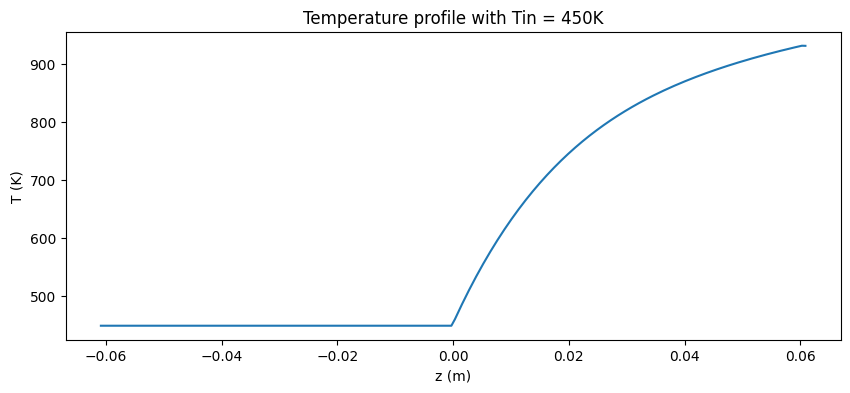

In [159]:
Ftot = np.sum(soln.y[:6], axis = 0)
h = soln.y[6]*Ain/Ftot #THIS IS NOT CORRECT BECAUSE THE AREA CALCULATION DOES NOT CHANGE CAN COMPARE THIS ONE TO USING CTOT*V
Cp = 33.2
T = h/Cp + 298.15
plt.figure(figsize=(10, 4))
plt.plot(soln.x, T)
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title(f'Temperature profile with Tin = {Tin}K')

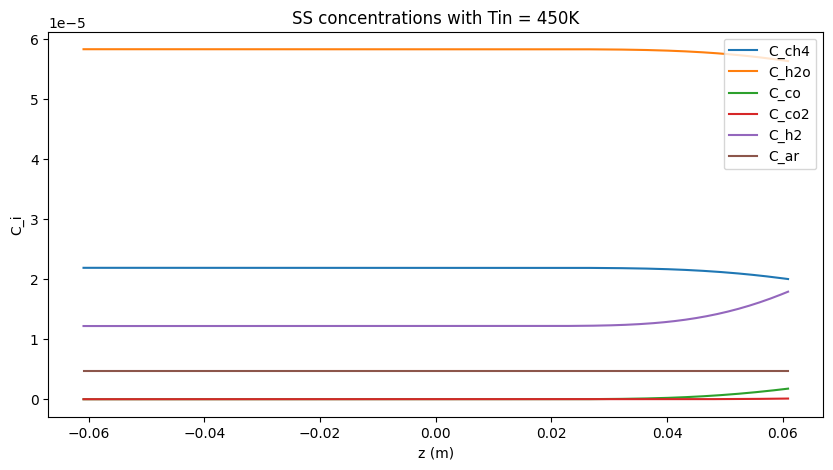

In [160]:
plt.figure(figsize=(10, 5))
plt.plot(soln.x, soln.y[0], label='C_ch4')
plt.plot(soln.x, soln.y[1], label='C_h2o')
plt.plot(soln.x, soln.y[2], label='C_co')
plt.plot(soln.x, soln.y[3], label='C_co2')
plt.plot(soln.x, soln.y[4], label='C_h2')
plt.plot(soln.x, soln.y[5], label='C_ar')
plt.xlabel('z (m)')
plt.ylabel('C_i')
plt.title(f'SS concentrations with Tin = {Tin}K')
plt.legend()

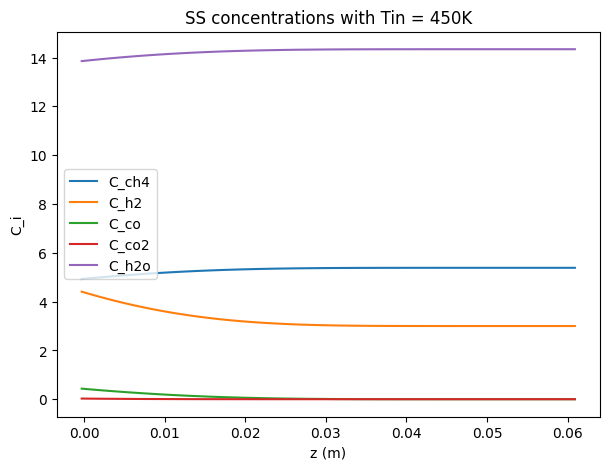

In [161]:
plt.figure(figsize=(7, 5))
plt.plot(soln.x[99:], soln.y[0,99:][::-1]/A/0.18, label='C_ch4')
plt.plot(soln.x[99:], soln.y[4,99:][::-1]/A/0.18, label='C_h2')
plt.plot(soln.x[99:], soln.y[2,99:][::-1]/A/0.18, label='C_co')
plt.plot(soln.x[99:], soln.y[3,99:][::-1]/A/0.18, label='C_co2')
plt.plot(soln.x[99:], soln.y[1,99:][::-1]/A/0.18, label='C_h2o')
plt.xlabel('z (m)')
plt.ylabel('C_i')
plt.title(f'SS concentrations with Tin = {Tin}K')
plt.legend()

Text(0.5, 1.0, 'Temperature profile with Tin = 450K')

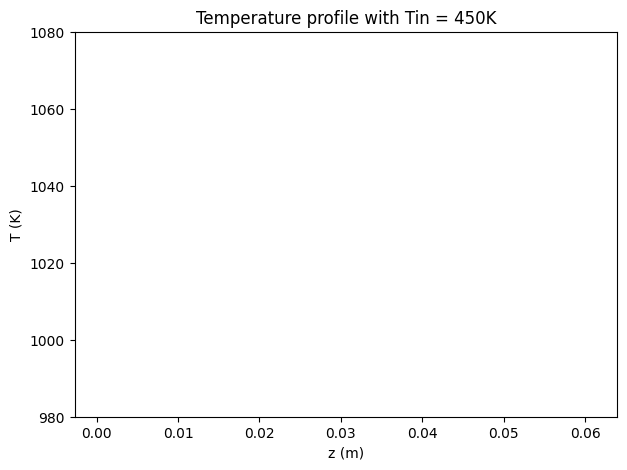

In [162]:
plt.figure(figsize=(7, 5))
plt.plot(soln.x[100:], soln.y[6,100:][::-1])
plt.ylim(980, 1080)
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title(f'Temperature profile with Tin = {Tin}K')

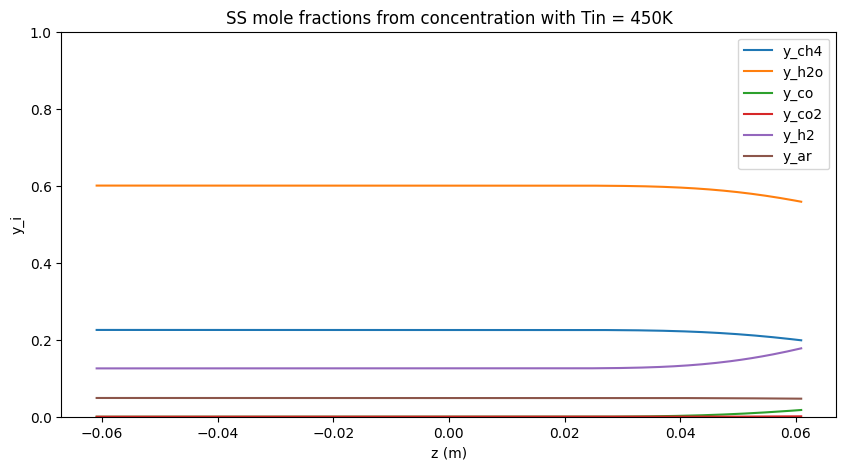

In [163]:
#mole fraction calculation
yplot = soln.y[:6]/np.sum(soln.y[:6], axis = 0)
plt.figure(figsize=(10, 5))
plt.plot(soln.x, yplot[0], label='y_ch4')
plt.plot(soln.x, yplot[1], label='y_h2o')
plt.plot(soln.x, yplot[2], label='y_co')
plt.plot(soln.x, yplot[3], label='y_co2')
plt.plot(soln.x, yplot[4], label='y_h2')
plt.plot(soln.x, yplot[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z (m)')
plt.ylabel('y_i')
plt.title(f'SS mole fractions from concentration with Tin = {Tin}K')
plt.legend()

199
200


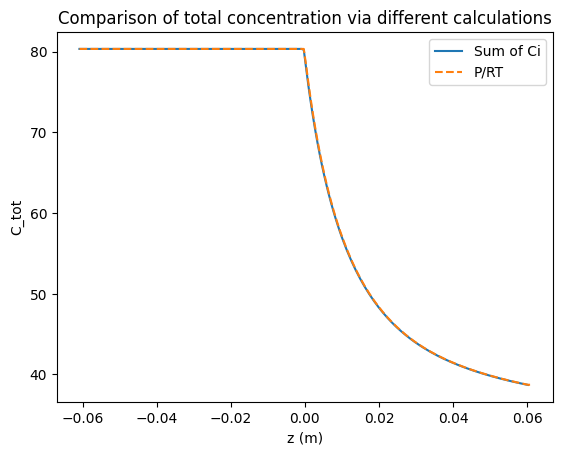

In [170]:
u = np.concatenate([vfinal[0]*Ain, vfinal[1]*A]) #this part is a little ugly but whatever
print(len(u))
print(len(soln.y[0]))
Csum = np.sum(soln.y[:6,:len(u)], axis = 0)/u

Ftot = np.sum(soln.y[:6], axis = 0)
h = soln.y[6]*Ain/Ftot #THIS IS NOT CORRECT BECAUSE THE AREA CALCULATION DOES NOT CHANGE CAN COMPARE THIS ONE TO USING CTOT*V
Cp = 33.2
T = h/Cp + 298.15
plt.plot(soln.x[:len(Csum)], Csum, label='Sum of Ci')
plt.plot(soln.x, P/(Rgas * T), label='P/RT', linestyle='--')
plt.xlabel('z (m)')
plt.ylabel('C_tot')
plt.title(f'Comparison of total concentration via different calculations')
plt.legend()

In [165]:
mf = np.dot(MM, soln.y[:6,-1])

print(f'{m0:.4e}')
print(f'{mf:.4e}')
print(f'mass balance off by {abs(mf - m0)/mf *100:.2}%')

1.6144e-03
1.6144e-03
mass balance off by 0.00031%


In [166]:
#Calculating heat loss to surr and heat balance
Ftot = np.sum(soln.y[:6], axis = 0)
h = soln.y[6]*A/Ftot #THIS IS NOT CORRECT BECAUSE THE AREA CALCULATION DOES NOT CHANGE CAN COMPARE THIS ONE TO USING CTOT*V
Cp = 33.2
T = h/Cp + 298.15
qsurr = np.sum(Uouter*dz*(-T[100:]+Ts))/L
print(qsurr)
print(q_furn + qsurr) #W/m2

# dH = Q. need to figure out dH 
# H = dh + standard heat of formation
# and then see if they match
_, _, _, heatsin = heats(T[0])
_, _, _, heatsout = heats(T[-1])
Hin = np.sum(soln.y[:6,0]*heatsin*10**3)
Hout = np.sum(soln.y[:6,-1]*heatsout*10**3)
print(Hin)
print(Hout)
print((Hout-Hin)/Souter) #W/m2

-13110.361228636308
187389.63877136368
-14.170244613363591
-6.846947053422982
5468.163295319558


Text(0.5, 1.0, 'Velocity profile along reactor')

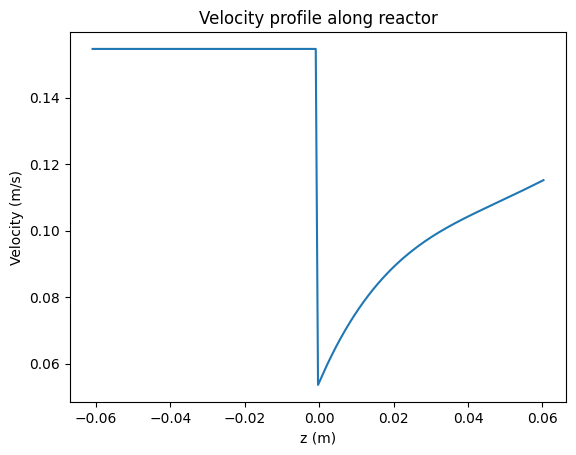

In [167]:
v = np.concatenate([vfinal[0], vfinal[1]])
plt.plot(soln.x[:len(v)], v)
plt.xlabel('z (m)')
plt.ylabel('Velocity (m/s)')
plt.title(f'Velocity profile along reactor')

In [168]:
#calculating the approximate overall heat transfer coeff
Tinmid = soln.y[6,50]
print(Tinmid)
Ctotin = P/(Rgas * Tinmid)
print(Ctotin)
dHsmr, dHwgs, Cps, _ = heats(Tinmid)
yin = soln.y[:6,50]/np.sum(soln.y[:6,50])
Cpg = np.sum(yin*Cps)
print(Cpg)
hi = Ctotin*Cpg*0.12
print(Ctotin*Cpg*0.12)

Toutmid = soln.y[6,150]
print(Toutmid)
Ctotout = P/(Rgas * Toutmid)
print(Ctotout)
dHsmr, dHwgs, Cps, _ = heats(Toutmid)
yout = soln.y[:6,150]/np.sum(soln.y[:6,150])
Cpg = np.sum(yout*Cps)
print(Cpg)
ho = Ctotout*Cpg*0.17
print(Ctotout*Cpg*0.17)

k = 71.8
ro  = 0.00225
ri = 0.003154/2

unUA = 1/(hi*2*np.pi*L*ri) + (np.log(ro/ri)/(2*np.pi*L*k)) + 1/(ho*2*np.pi*L*ro)
UA = 1/unUA
print(UA)
print(UA/Sinner)

print(0.2/Souter)

62265.313121778505
0.5794834544877465
-146396.69350665098
-10180.135401458154
217989.84969928017
0.1655201780832668
-5928271.150732895
-166812.24442118432
-6.37702036876467
-7406.928034202508
149.33609485516806


61992.313121778505


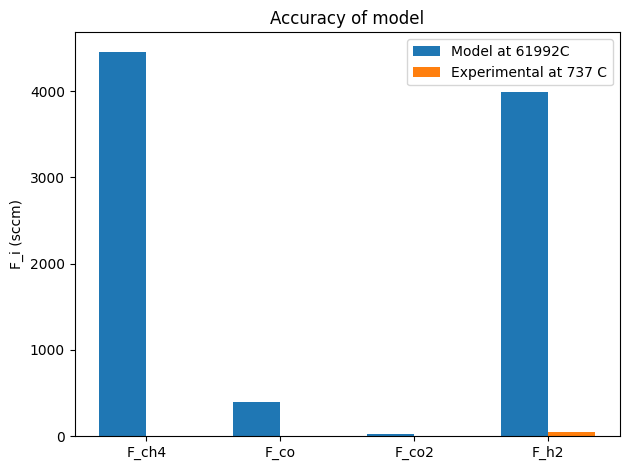

In [169]:
Tmid = soln.y[6,60]-273
print(Tmid)

# Define categories
Cexp = [3.492847043, 7.305258501, 3.329101979, 49.97503291] #this is in flowrate sccm

categories = ['F_ch4', 'F_co', 'F_co2', 'F_h2']
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

scale = 2
#molar flowrates
CH4 = soln.y[0,-1] * (soln.y[6,-1])/273 * 1/P / (7.4358 * 10**-7) / scale
CO = soln.y[2,-1] * (soln.y[6,-1])/273 * 1/P / (7.4358 * 10**-7) / scale
CO2 = soln.y[3,-1] * (soln.y[6,-1])/273 * 1/P / (7.4358 * 10**-7) / scale
H2 = soln.y[4,-1] * (soln.y[6,-1])/273 * 1/P / (7.4358 * 10**-7) / scale

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, [CH4, CO, CO2, H2], width, label=f'Model at {int(Tmid)}C')
bars2 = ax.bar(x + width/2, Cexp, width, label='Experimental at 737 C')

# Labels and legend
ax.set_ylabel('F_i (sccm)')
ax.set_title(f'Accuracy of model')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()